In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from tabulate import tabulate

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, confusion_matrix
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.model_selection import train_test_split

from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder

from dimensionality_reduction import run_dimensionality_reduction, plot_embeddings
from scipy.io import arff
import time

# Eye State Dataset

## Load and process data

In [3]:
# Load the data into a Pandas DataFrame
data_eeg_eyestate = arff.loadarff('./data/EEG Eye State.arff')
df_eeg_eyestate = pd.DataFrame(data_eeg_eyestate[0])

# turn the eyeDetection column into a binary column
# df_eeg_eyestate['eyeDetection'] = df_eeg_eyestate['eyeDetection'].map({b'0': 0, b'1': 1})

# Define the features and target
X = df_eeg_eyestate.drop('eyeDetection', axis=1)
y = df_eeg_eyestate['eyeDetection']

# Converts eyeDetection to int
y = y.astype(int)

In [4]:
# Randomize the data
X = X.sample(frac=1, random_state=0)
y = y.sample(frac=1, random_state=0)

In [5]:
class Dataset:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

In [6]:
eye_dataset = Dataset(*train_test_split(X, y, test_size=0.3, random_state=42))

## Classifiers

In [7]:
# Define the classifiers you want to test
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Naive Bayes', GaussianNB()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('XGBoost', XGBClassifier()),
]

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', None)
])

In [8]:
def run_pipeline(dataset, pipeline, classifier_name, classifier):
    start_time = time.time()
    pipeline.set_params(classifier=classifier)

    pipeline.fit(dataset.X_train, dataset.y_train)
    y_pred = pipeline.predict(dataset.X_test)

    cm = confusion_matrix(dataset.y_test, y_pred)
    accuracy = accuracy_score(dataset.y_test, y_pred)
    precision = precision_score(dataset.y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(dataset.y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(dataset.y_test, y_pred, average='weighted', zero_division=0)
    end_time = time.time()

    return classifier_name, accuracy, precision, recall, f1, cm, end_time - start_time



def test_classifiers(dataset, pipeline, classifiers):
    print("{:<20} {:<8} {:<8} {:<8} {:<8} {:<8}".format("Model", "Accuracy", "Precision", "Recall", "F1", "Time"))

    highest_f1 = 0
    best_cm = None
    best_classifier_name = ""

    for classifier_name, classifier in classifiers:
        name, accuracy, precision, recall, f1, cm, time_taken = run_pipeline(dataset, pipeline, classifier_name, classifier)
        print("{:<20} {:.3f}    {:.3f}    {:.3f}    {:.3f}    {:.3f}".format(name, accuracy, precision, recall, f1, time_taken))
        if f1 > highest_f1:
            highest_f1 = f1
            best_cm = cm
            best_classifier_name = name

    print("\nBest classifier (by F1 score):", best_classifier_name)
    print("Confusion Matrix for", best_classifier_name)
    unique_labels = np.unique(dataset.y_test)
    print(pd.DataFrame(best_cm, index=unique_labels, columns=unique_labels))



In [9]:
test_classifiers(eye_dataset, pipeline, classifiers)

Model                Accuracy Precision Recall   F1       Time    
Logistic Regression  0.589    0.582    0.589    0.572    0.049
K-Nearest Neighbors  0.832    0.832    0.832    0.832    0.190
Decision Tree        0.829    0.830    0.829    0.830    0.081
Random Forest        0.930    0.931    0.930    0.930    1.368
SVM                  0.626    0.655    0.626    0.578    3.122
Naive Bayes          0.444    0.470    0.444    0.294    0.010
AdaBoost             0.745    0.744    0.745    0.743    0.406
Gradient Boosting    0.819    0.821    0.819    0.818    1.761
Extra Trees          0.949    0.949    0.949    0.949    0.717
XGBoost              0.930    0.930    0.930    0.930    1.010

Best classifier (by F1 score): Extra Trees
Confusion Matrix for Extra Trees
      0     1
0  2431    65
1   165  1833


## Clustering

In [10]:
clustering_algorithms = [
    ('K-Means', KMeans(n_clusters=2, n_init=10)),
    ('Agglomerative', AgglomerativeClustering(n_clusters=2)),
    ('DBSCAN', DBSCAN(eps=0.5, min_samples=5))
]

In [11]:
def cluster_distribution(y_true, y_pred):
    distribution = {}
    for i in range(len(y_true)):
        cluster = y_pred[i]
        true_label = y_true.iloc[i]
        if cluster not in distribution:
            distribution[cluster] = {}
        if true_label not in distribution[cluster]:
            distribution[cluster][true_label] = 0
        distribution[cluster][true_label] += 1
    return distribution

def run_clustering(dataset, clustering_name, clustering):
    start_time = time.time()
    clustering.fit(dataset.X_train)
    y_pred = clustering.fit_predict(dataset.X_test)
    
    ari = adjusted_rand_score(dataset.y_test, y_pred)
    homogeneity = homogeneity_score(dataset.y_test, y_pred)
    completeness = completeness_score(dataset.y_test, y_pred)
    v_measure = v_measure_score(dataset.y_test, y_pred)
    end_time = time.time()
    
    distribution = cluster_distribution(dataset.y_test, y_pred)

    return clustering_name, ari, homogeneity, completeness, v_measure, end_time - start_time, distribution

def test_clustering_algorithms(dataset, clustering_algorithms):
    print("{:<25} {:<8} {:<8} {:<8} {:<8} {:<8}".format("Algorithm", "ARI", "Homogeneity", "Completeness", "V-measure", "Time"))

    for clustering_name, clustering in clustering_algorithms:
        name, ari, homogeneity, completeness, v_measure, time_taken, distribution = run_clustering(dataset, clustering_name, clustering)
        print("{:<25} {:.3f}    {:.3f}      {:.3f}        {:.3f}      {:.3f}".format(name, ari, homogeneity, completeness, v_measure, time_taken))
        print("Cluster Distribution:")
        for cluster, labels in distribution.items():
            print(f"  Cluster {cluster}: {labels}")
        print()


In [12]:
test_clustering_algorithms(eye_dataset, clustering_algorithms)

Algorithm                 ARI      Homogeneity Completeness V-measure Time    
K-Means                   0.006    0.002      0.004        0.002      0.162
Cluster Distribution:
  Cluster 0: {1: 1753, 0: 2266}
  Cluster 1: {1: 245, 0: 230}

Agglomerative             -0.003    0.001      0.003        0.002      1.972
Cluster Distribution:
  Cluster 0: {1: 1888, 0: 2311}
  Cluster 1: {1: 110, 0: 185}

DBSCAN                    0.000    0.000      1.000        0.000      0.068
Cluster Distribution:
  Cluster -1: {1: 1998, 0: 2496}



## Dimensionality Reduction Visualization

Running PCA
Running UMAP


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


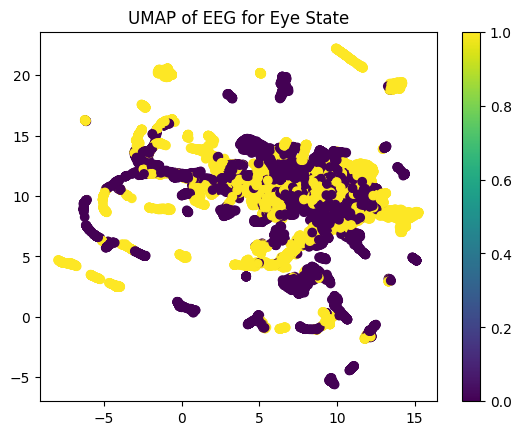

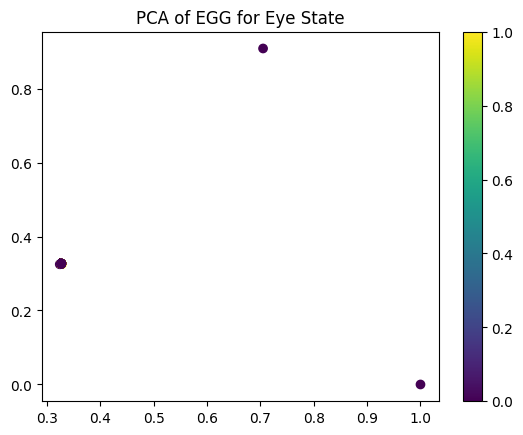

In [13]:
reductions = run_dimensionality_reduction(X.to_numpy())

plot_embeddings(reductions["umap2"], y, 'UMAP of EEG for Eye State')
plot_embeddings(reductions["pca5"], y, 'PCA of EGG for Eye State')

# 5 Stimuli vs EEG and Affect

## Load and Preprocess Data

In [14]:
df = pd.read_csv('./data/Sujeto1.csv')

# Save the EEG columns and MarkerValueInt column as separate arrays
eeg_columns = [f'EEG.{col}' for col in ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']]
affect_columns = [f'PM.{col}.Scaled' for col in ['Engagement', 'Excitement', 'Stress', 'Relaxation', 'Interest', 'Focus']]

marker_value_int = df['MarkerValueInt'].to_numpy()
eeg = df[eeg_columns].to_numpy()
affect = df[affect_columns].to_numpy()
occ = df[["EEG.O1", "EEG.O2"]].to_numpy()

In [15]:
def fill_and_drop(df):
    df = df.dropna(how="all")
    df = df.fillna(method='ffill')
    return df.dropna()

# eeg and marker value int as class
df_eeg = pd.DataFrame(eeg, columns=eeg_columns)
df_eeg['stimulus'] = marker_value_int
df_eeg = fill_and_drop(df_eeg)
# drop the stimulus column and convert to numpy
eeg = df_eeg.drop(columns=['stimulus']).to_numpy()

# affect and marker value int as class
df_affect = pd.DataFrame(affect, columns=affect_columns)
df_affect['stimulus'] = marker_value_int
df_affect = fill_and_drop(df_affect)
affect = df_affect.drop(columns=['stimulus']).to_numpy()

# occ and marker value int as class
df_occ = pd.DataFrame(occ, columns=["EEG.O1", "EEG.O2"])
df_occ['stimulus'] = marker_value_int
df_occ = fill_and_drop(df_occ)
occ = df_occ.drop(columns=['stimulus']).to_numpy()


def split_dataset(df):
    X = df.drop(columns=['stimulus'])
    y = df['stimulus']
    return Dataset(*train_test_split(X, y, test_size=0.3, random_state=42))

eeg_dataset = split_dataset(df_eeg)
affect_dataset = split_dataset(df_affect)
occ_dataset = split_dataset(df_occ)

In [16]:
test_classifiers(eeg_dataset, pipeline, classifiers)

Model                Accuracy Precision Recall   F1       Time    
Logistic Regression  0.263    0.263    0.263    0.262    0.265
K-Nearest Neighbors  0.885    0.886    0.885    0.885    8.178
Decision Tree        0.637    0.637    0.637    0.637    1.142
Random Forest        0.870    0.871    0.870    0.870    17.533
SVM                  0.467    0.480    0.467    0.467    149.087
Naive Bayes          0.223    0.282    0.223    0.143    0.061
AdaBoost             0.328    0.329    0.328    0.326    3.060
Gradient Boosting    0.470    0.480    0.470    0.470    71.803
Extra Trees          0.899    0.900    0.899    0.899    6.609


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4], got [1. 2. 3. 4. 5.]